In [1]:
import src.gen_synthetic as gen_data
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft
import src.onlineSLE as utility
import periodicity_detection as period



## Generate Syn1 and Syn2 (noise level 0.10\sigma)

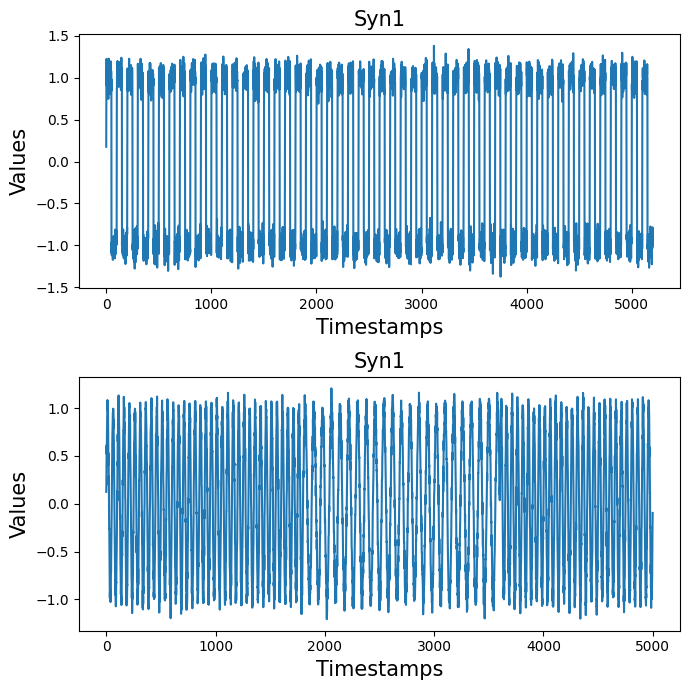

In [2]:
noise_level = 0.10
syn1 = gen_data.generate_syn1(residual_rate=noise_level, is_export=False)
syn2 = gen_data.generate_syn2(residual_rate=noise_level, is_export=False)
dataset_names = ['syn1', 'syn2']
datasets = [syn1['ts'], syn2['ts']]
answers = [syn1['ground_truth'], syn2['ground_truth']]
sliding_window_sizes = [500, 400]

fig, axes = plt.subplots(2, 1, figsize=(7, 7))

axes[0].plot(syn1['ts'])
axes[0].set_title('Syn1', fontsize=15)
axes[0].set_xlabel('Timestamps', fontsize=15)
axes[0].set_ylabel('Values', fontsize=15)

axes[1].plot(syn2['ts'])
axes[1].set_title('Syn1', fontsize=15)
axes[1].set_xlabel('Timestamps', fontsize=15)
axes[1].set_ylabel('Values', fontsize=15)
plt.tight_layout()
plt.show()

## Find length

In [3]:
for dataset_name, dataset, answer, sliding_window_size in zip (dataset_names, datasets, answers, sliding_window_sizes):
    find_length_result = []
    dataset = np.array(dataset)
    for idx in range(len(dataset) - sliding_window_size + 1):
        W = dataset[idx:sliding_window_size + idx]
        SLE_result = period.find_length(W)
        
        find_length_result.append({'idx_win': sliding_window_size + idx,
                                    'answer': answer[sliding_window_size + idx - 1],
                                    'result': SLE_result})
    
    print(utility.result_aggregation(dataset_name, 'find_length',find_length_result))

[{'dataset_name': 'syn1', 'algorithms': 'find_length', 'error_bound': 0, 'accuracy_ratio': 1.0}, {'dataset_name': 'syn1', 'algorithms': 'find_length', 'error_bound': 20, 'accuracy_ratio': 1.0}]
[{'dataset_name': 'syn2', 'algorithms': 'find_length', 'error_bound': 0, 'accuracy_ratio': 0.681}, {'dataset_name': 'syn2', 'algorithms': 'find_length', 'error_bound': 20, 'accuracy_ratio': 0.873}]


## AutoPeriod

In [5]:
for dataset_name, dataset, answer, sliding_window_size in zip (dataset_names, datasets, answers, sliding_window_sizes):
    autoperiod_result = []
    dataset = np.array(dataset)
    for idx in range(len(dataset) - sliding_window_size + 1):
        W = dataset[idx:sliding_window_size + idx]
        SLE_result = period.autoperiod(W)
        
        autoperiod_result.append({'idx_win': sliding_window_size + idx,
                                    'answer': answer[sliding_window_size + idx - 1],
                                    'result': SLE_result})
    
    print(utility.result_aggregation(dataset_name, 'autoperiod',autoperiod_result))

[{'dataset_name': 'syn1', 'algorithms': 'autoperiod', 'error_bound': 0, 'accuracy_ratio': 1.0}, {'dataset_name': 'syn1', 'algorithms': 'autoperiod', 'error_bound': 20, 'accuracy_ratio': 1.0}]
[{'dataset_name': 'syn2', 'algorithms': 'autoperiod', 'error_bound': 0, 'accuracy_ratio': 0.694}, {'dataset_name': 'syn2', 'algorithms': 'autoperiod', 'error_bound': 20, 'accuracy_ratio': 0.91}]


## SAZED using rpy2

In [10]:
## For facilitating reproduction, we show the evaluation using the Python-R bridge (rpy2 library).

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
sazedR = importr('sazedR')          # sazedR in CRAN

for dataset_name, dataset, answer, sliding_window_size in zip(dataset_names, datasets, answers, sliding_window_sizes):
    sazedR_result = []
    dataset = np.array(dataset)
    for idx in range(len(dataset) - sliding_window_size + 1):
        W = dataset[idx:sliding_window_size + idx]
        W = robjects.FloatVector(W)
        SLE_result = sazedR.sazed(W)
        SLE_result = SLE_result[0]
        sazedR_result.append({'idx_win': sliding_window_size + idx,
                                  'answer': answer[sliding_window_size + idx - 1],
                                  'result': SLE_result})

    print(utility.result_aggregation(dataset_name, 'sazedR', sazedR_result))

[{'dataset_name': 'syn1', 'algorithms': 'sazedR', 'error_bound': 0, 'accuracy_ratio': 1.0}, {'dataset_name': 'syn1', 'algorithms': 'sazedR', 'error_bound': 20, 'accuracy_ratio': 1.0}]
[{'dataset_name': 'syn2', 'algorithms': 'sazedR', 'error_bound': 0, 'accuracy_ratio': 0.647}, {'dataset_name': 'syn2', 'algorithms': 'sazedR', 'error_bound': 20, 'accuracy_ratio': 0.908}]


## OnlineSLE

In [8]:
for dataset_name, dataset, answer, sliding_window_size in zip (dataset_names, datasets, answers, sliding_window_sizes):
    ## offline mode
    onlineSLE_result = []
    W = dataset[:sliding_window_size]
    mathcal_F = fft(W)
    N = len(mathcal_F)
    k = np.arange(N)
    twiddle = np.exp(2j * np.pi * k / N)   # twiddle for SDFT

    xfreq, periodogram_den = utility.peridogram(sliding_window_size, mathcal_F)
    peak_index = utility.get_period_hints(periodogram_den)
    if peak_index > 1:
        frequency = xfreq[peak_index]
        SLE_result = round(1 / frequency)
    else:
        SLE_result = 1
    onlineSLE_result.append({'idx_win': sliding_window_size,
                    'answer': answer[sliding_window_size - 1],
                    'result': SLE_result})
    
    ## online mode
    for idx, x_t in enumerate(dataset[sliding_window_size:]):
        x_oldest = W[0]
        W = W[1:]
        W = np.append(W, x_t)
        mathcal_F = utility.update_sDFT(mathcal_F, x_oldest, x_t,twiddle)
        xfreq, periodogram_den = utility.peridogram(sliding_window_size, mathcal_F)
        peak_index = utility.get_period_hints(periodogram_den)
        if peak_index > 1:
            frequency = xfreq[peak_index]
            SLE_result = round(1 / frequency)
        else:
            SLE_result = 1
        
        onlineSLE_result.append({'idx_win': 1 + sliding_window_size + idx,
                                    'answer': answer[sliding_window_size + idx],
                                    'result': SLE_result})
        
    print(utility.result_aggregation(dataset_name, 'onlineSLE', onlineSLE_result))

[{'dataset_name': 'syn1', 'algorithms': 'onlineSLE', 'error_bound': 0, 'accuracy_ratio': 1.0}, {'dataset_name': 'syn1', 'algorithms': 'onlineSLE', 'error_bound': 20, 'accuracy_ratio': 1.0}]
[{'dataset_name': 'syn2', 'algorithms': 'onlineSLE', 'error_bound': 0, 'accuracy_ratio': 0.913}, {'dataset_name': 'syn2', 'algorithms': 'onlineSLE', 'error_bound': 20, 'accuracy_ratio': 0.913}]
